In [1]:
import sys
import os

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import models
from skimage.transform import resize

sys.path.insert(0, os.path.abspath('..'))

from src.utils.load_cfg import ConfigLoader
from src.factories import ModelFactory
from src.factories import DatasetFactory
from src.utils.misc import MiscUtils
from src.models.pytorch_ssim.ssim import SSIM

from tools.complexity import (get_model_complexity_info,
                              is_supported_instance,
                              flops_to_string,
                              get_model_parameters_number)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})


dataset_cfg = '../configs/dataset_cfgs/epickitchens_short.yaml'
train_cfg = '../configs/train_cfgs/train_san_freeze_short.yaml'
model_cfg = '../configs/model_cfgs/pipeline2_rgbspec_san19pairfreeze_actreggru_halluconvlstm.yaml'
weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment3/epoch_00049.model'
model_cfg_mod = None
# weight = '../saved_models/san19freeze_halluconvlstm_actreggru/dim32_layer1_nsegment10/epoch_00049.model'
# model_cfg_mod = {'num_segments': 10, 'hallu_model_cfg': 'exp_cfgs/haluconvlstm_32_1.yaml'}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Deprocess data for visualization
def deprocess_rgb(rgb, num_segments):
    rgb = rgb.cpu().numpy()
    assert rgb.shape[0] == 1
    _, _, h, w = rgb.shape
    rgb = rgb.reshape([num_segments, 3, h, w]).transpose(0, 2, 3, 1)
    rgb *= 1  # std
    rgb += np.array([104, 117, 128])  # mean
    rgb = rgb.astype(np.uint8)
    return rgb


def deprocess_spec(spec, num_segments):
    spec = spec.cpu().numpy()
    assert spec.shape[0] == 1
    _, _, h, w = spec.shape
    spec = spec.reshape([num_segments, h, w])
    return spec


def display_input(sample, num_segments):
    # Deprocess inputs
    rgb = deprocess_rgb(sample['RGB'], num_segments)
    spec = deprocess_spec(sample['Spec'], num_segments)

    # Display input RGB
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  RGB\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(cv2.cvtColor(rgb[i], cv2.COLOR_BGR2RGB))
        axes[i].axis('off')

    # Display input Spec
    fig, axes = plt.subplots(1, num_segments, figsize=(3*num_segments, 5))
    fig.suptitle('='*30+'\n  Spec\n'+'='*30, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_segments):
        axes[i].imshow(spec[i], cmap='viridis')
        axes[i].axis('off')

In [3]:
# Load configurations
model_name, model_params = ConfigLoader.load_model_cfg(model_cfg)
dataset_name, dataset_params = ConfigLoader.load_dataset_cfg(dataset_cfg)
train_params = ConfigLoader.load_train_cfg(train_cfg)

if model_cfg_mod is not None:
    model_params.update(model_cfg_mod)

dataset_params.update({
    'modality': model_params['modality'],
    'num_segments': model_params['num_segments'],
    'new_length': model_params['new_length'],
})

# Build model
model_factory = ModelFactory()
model = model_factory.generate(model_name, device=device, model_factory=model_factory, **model_params)
model.load_model(weight)
model = model.to(device)

# Get training augmentation and transforms
train_augmentation = MiscUtils.get_train_augmentation(model.modality, model.crop_size)
train_transform, val_transform = MiscUtils.get_train_val_transforms(
    modality=model.modality,
    input_mean=model.input_mean,
    input_std=model.input_std,
    scale_size=model.scale_size,
    crop_size=model.crop_size,
    train_augmentation=train_augmentation,
)

# Data loader
dataset_factory = DatasetFactory()
loader_params = {
    'batch_size': train_params['batch_size'],
    'num_workers': train_params['num_workers'],
    'pin_memory': True,
}

val_dataset = dataset_factory.generate(dataset_name, mode='val', transform=val_transform, **dataset_params)
val_loader = DataLoader(val_dataset, shuffle=False, **loader_params)

In [4]:
def collect_flops(model, units='GMac', precision=3):
    """Wrapper to collect flops and number of parameters at each layer"""
    total_flops = model.compute_average_flops_cost()

    def accumulate_flops(self):
        if is_supported_instance(self):
            return self.__flops__ / model.__batch_counter__
        else:
            sum = 0
            for m in self.children():
                sum += m.accumulate_flops()
            return sum

    def flops_repr(self):
        accumulated_flops_cost = self.accumulate_flops()
        return ', '.join([flops_to_string(accumulated_flops_cost, units=units, precision=precision),
                          '{:.3%} MACs'.format(accumulated_flops_cost / total_flops),
                          self.original_extra_repr()])

    def add_extra_repr(m):
        m.accumulate_flops = accumulate_flops.__get__(m)
        flops_extra_repr = flops_repr.__get__(m)
        if m.extra_repr != flops_extra_repr:
            m.original_extra_repr = m.extra_repr
            m.extra_repr = flops_extra_repr
            assert m.extra_repr != m.original_extra_repr

    def del_extra_repr(m):
        if hasattr(m, 'original_extra_repr'):
            m.extra_repr = m.original_extra_repr
            del m.original_extra_repr
        if hasattr(m, 'accumulate_flops'):
            del m.accumulate_flops

    model.apply(add_extra_repr)

    # Retrieve flops and param at each layer and sub layer (2 levels)
    flops_dict, param_dict = {}, {}
    for i in model._modules.keys():
        item = model._modules[i]
        if isinstance(model._modules[i], torch.nn.modules.container.Sequential):
            for j in model._modules[i]._modules.keys():
                key = '{}-{}'.format(i, j)
                flops_dict[key] = item._modules[j].accumulate_flops()
                param_dict[key] = get_model_parameters_number(item._modules[j])
        else:
            flops_dict[i] = item.accumulate_flops()
            param_dict[i] = get_model_parameters_number(item)

    model.apply(del_extra_repr)
    return flops_dict, param_dict

In [5]:
print('RGB model')
rgb_model = model.light_model.rgb

macs, params = get_model_complexity_info(
    rgb_model,
    (3, 224, 244),
    as_strings=True,
    print_per_layer_stat=False,
)

print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print('\n{:<15} {:>12} {:>12} {:>12} {:>12}\n'.format(
    'Layer', 'Flops (GMac)', 'Param (M)', 'AccFlops', 'AccParam') + '-'*67)

flops_dict, param_dict = collect_flops(rgb_model)
total_flops, total_param = 0, 0
flops_rgb_part1 = 0
for k in flops_dict:
    total_flops += flops_dict[k]*1e-9
    total_param += param_dict[k]*1e-6
    if k == 'layer3-0':
        flops_rgb_part1 = total_flops * 1e9
    print('{:<15} {:>12.5f} {:>12.5f} {:>12.2f} {:>12.2f}'.format(
        k, flops_dict[k]*1e-9, param_dict[k]*1e-6, total_flops, total_param))
del rgb_model
flops_rgb_part2 = total_flops*1e9 - flops_rgb_part1


# ----------------------------------------------------------------------------
print('\n\nSpec model')
spec_model = model.light_model.spec

macs, params = get_model_complexity_info(
    spec_model,
    (1, 224, 244),
    as_strings=True,
    print_per_layer_stat=False,
)

print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print('\n{:<15} {:>12} {:>12} {:>12} {:>12}\n'.format(
    'Layer', 'Flops (GMac)', 'Param (M)', 'AccFlops', 'AccParam') + '-'*67)

flops_dict, param_dict = collect_flops(spec_model)
total_flops, total_param = 0, 0
flops_spec_part1 = 0
for k in flops_dict:
    total_flops += flops_dict[k]*1e-9
    total_param += param_dict[k]*1e-6
    if k == 'layer3-0':
        flops_spec_part1 = total_flops * 1e9
    print('{:<15} {:>12.5f} {:>12.5f} {:>12.2f} {:>12.2f}'.format(
        k, flops_dict[k]*1e-9, param_dict[k]*1e-6, total_flops, total_param))
del spec_model
flops_spec_part2 = total_flops*1e9 - flops_spec_part1


# ----------------------------------------------------------------------------
# create dummy model because the one in real model checks for num_segment
# here we only look at complexity per frame
print('\n\nHallu model')
hallu_model = model_factory.generate(
    model_name='HalluConvLSTM',
    device=device,
    num_segments=1,  # Test per frame
    attention_dim=[32, 14, 14],
    rnn_input_dim=32,
    rnn_hidden_dim=32,
    rnn_num_layers=1,
    has_encoder_decoder=True,
).to(device)
macs, params = get_model_complexity_info(
    hallu_model,
    (1, 32, 14, 14),  # Test per frame
    as_strings=True,
    print_per_layer_stat=False,
)

print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print('\n{:<15} {:>12} {:>12} {:>12} {:>12}\n'.format(
    'Layer', 'Flops (GMac)', 'Param (M)', 'AccFlops', 'AccParam') + '-'*67)

flops_dict, param_dict = collect_flops(hallu_model)
total_flops, total_param = 0, 0
for k in flops_dict:
    total_flops += flops_dict[k]*1e-9
    total_param += param_dict[k]*1e-6
    print('{:<15} {:>12.5f} {:>12.5f} {:>12.2f} {:>12.2f}'.format(
        k, flops_dict[k]*1e-9, param_dict[k]*1e-6, total_flops, total_param))
del hallu_model
flops_hallu = total_flops*1e9


# ----------------------------------------------------------------------------
# create dummy model because the one in real model checks for num_segment
# here we only look at complexity per frame
print('\n\nActreg model')
actreg_model = model_factory.generate(
    model_name='ActregGRU',
    device=device,
    modality=['RGB', 'Spec'],
    num_segments=1,  # Test per frame
    num_class=[125, 352],
    dropout=0.5,
    feature_dim=2048,
    rnn_input_size=512,
    rnn_hidden_size=512,
    rnn_num_layers=1,
).to(device)

macs, params = get_model_complexity_info(
    actreg_model,
    (1, 2*2048),  # Test 2 modalities
    as_strings=True,
    print_per_layer_stat=False,
)

print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))
print('\n{:<15} {:>12} {:>12} {:>12} {:>12}\n'.format(
    'Layer', 'Flops', 'Param', 'AccFlops', 'AccParam') + '-'*67)

flops_dict, param_dict = collect_flops(actreg_model)
total_flops, total_param = 0, 0
for k in flops_dict:
    total_flops += flops_dict[k]
    total_param += param_dict[k]
    print('{:<15} {:>12.0f} {:>12.0f} {:>12.0f} {:>12.0f}'.format(
        k, flops_dict[k], param_dict[k], total_flops, total_param))
del actreg_model
flops_actreg = total_flops

RGB model
Computational complexity:       4.08 GMac
Number of parameters:           15.55 M 

Layer           Flops (GMac)    Param (M)     AccFlops     AccParam
-------------------------------------------------------------------
conv_in              0.01049      0.00019         0.01         0.00
bn_in                0.00700      0.00013         0.02         0.00
conv0                0.05597      0.00410         0.07         0.00
bn0                  0.00175      0.00013         0.08         0.00
layer0-0             0.05012      0.00287         0.13         0.01
layer0-1             0.05012      0.00287         0.18         0.01
layer0-2             0.05012      0.00287         0.23         0.01
conv1                0.05597      0.01638         0.28         0.03
bn1                  0.00175      0.00051         0.28         0.03
layer1-0             0.24619      0.04245         0.53         0.07
layer1-1             0.24619      0.04245         0.78         0.11
layer1-2             0

In [6]:
print(int(flops_rgb_part1), int(flops_rgb_part2))
print(int(flops_spec_part1), int(flops_spec_part2))

2338938028 1745984758
2331942060 1745984758


In [7]:
# Forward a sample
sample_id = 64

# Get a sample
for i, (sample, target) in enumerate(val_loader):
    sample = {k: v.to(device) for k, v in sample.items()}
    target = {k: v.to(device) for k, v in target.items()}

    if i == sample_id:
        break

# Forward
model.eval()
output = model(sample)

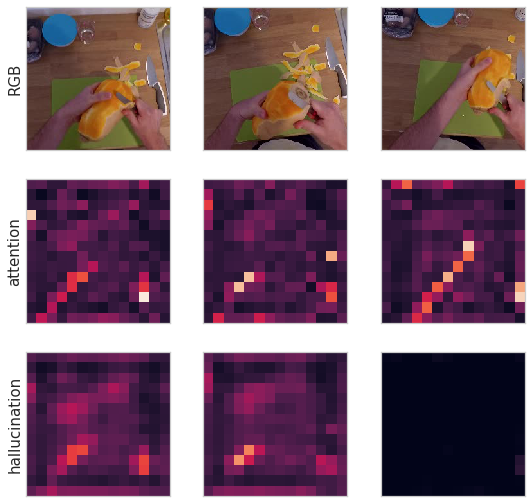

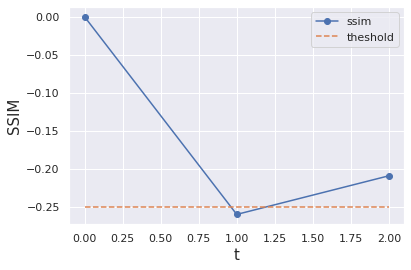

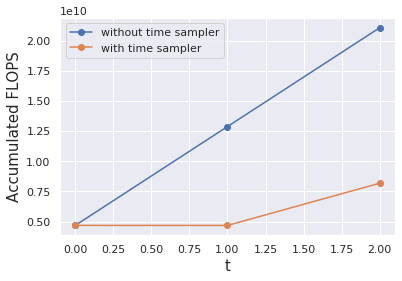

In [11]:
rgb = deprocess_rgb(sample['RGB'], model.num_segments)
spec = deprocess_spec(sample['Spec'], model.num_segments)
attn = model._attn[0]
hallu = model._hallu[0]
theta = -0.25

# SSIM criterion
ssim_criterion = SSIM(window_size=3, channel=attn.shape[1])
ssim_list = np.zeros(model.num_segments)

# ----------------------------------------------------------------------------
# Visualize hallucination
sns.set_style("whitegrid", {'axes.grid' : False})
fig, axes = plt.subplots(3, model.num_segments, figsize=(3*model.num_segments, 9))
foo = attn.mean(dim=1).cpu().detach().numpy()
bar = hallu.mean(dim=1).cpu().detach().numpy()
vmin = min(foo.min(), bar.min())
vmax = max(foo.max(), bar.max())

for t in range(model.num_segments):
    axes[0, t].imshow(cv2.cvtColor(rgb[t], cv2.COLOR_BGR2RGB))
    axes[1, t].imshow(attn[t].mean(dim=0).cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    axes[2, t].imshow(hallu[t].mean(dim=0).cpu().detach().numpy(), vmin=vmin, vmax=vmax)
    
    # Compute SSIM
    if t > 0:
        ssim = -ssim_criterion(attn[t].unsqueeze(dim=0), hallu[t-1].unsqueeze(dim=0)).item()
        ssim_list[t] = ssim
        
for ax in axes.ravel():
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)

axes[0, 0].set_ylabel('RGB', fontsize=15)
axes[1, 0].set_ylabel('attention', fontsize=15)
axes[2, 0].set_ylabel('hallucination', fontsize=15)

# ----------------------------------------------------------------------------

sns.set()
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(model.num_segments), ssim_list, '-o', label='ssim')
ax.plot(np.arange(model.num_segments), [theta]*model.num_segments, '--', label='theshold')
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('SSIM', fontsize=15)
plt.legend()

# ----
flops_cumsum_normal = np.zeros(model.num_segments)
flops_cumsum_sampled = np.zeros(model.num_segments)

flops_cumsum_normal[0] = flops_rgb_part1 + flops_spec_part1 + flops_hallu + flops_actreg
flops_cumsum_sampled[0] = flops_cumsum_normal[0]

for t in range(1, model.num_segments):
    flops_cumsum_normal[t] = flops_cumsum_normal[t-1] + flops_rgb_part1 + flops_spec_part1 + flops_hallu + \
                             + flops_rgb_part2 + flops_spec_part2 + flops_actreg
    flops_cumsum_sampled[t] = flops_cumsum_sampled[0-1]  + flops_rgb_part1 + flops_spec_part1 + flops_hallu
    if ssim_list[t] > theta:
        flops_cumsum_sampled[t] += flops_rgb_part2 + flops_spec_part2 + flops_actreg
        
fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(model.num_segments), flops_cumsum_normal, '-o', label='without time sampler')
ax.plot(np.arange(model.num_segments), flops_cumsum_sampled, '-o', label='with time sampler')
ax.set_xlabel('t', fontsize=15)
ax.set_ylabel('Accumulated FLOPS', fontsize=15)
plt.legend()